## Importar librerias

In [6]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

%matplotlib inline
plt.style.use('fivethirtyeight')
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.rcParams['figure.figsize'] = (12, 9)


## Importar dataset

In [2]:
df = pd.read_csv('/content/uoc_train.csv')
df.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
0,-0.458258,-0.579012,2.886009,-0.075516,1.674060,-2.431912,0.534850,-0.846473,2
1,1.626615,-0.028332,-1.443184,-1.007447,-0.989093,1.202627,-0.038211,-1.298616,0
2,1.721356,-0.137676,-1.322593,-1.333187,-0.723713,0.843285,-0.588495,0.066682,0
3,-0.715103,3.265915,-0.791030,-2.967881,2.497628,-0.277387,-0.551611,0.668354,2
4,2.944098,0.197871,-2.257025,1.032789,-4.104693,4.716115,-0.380813,-1.393825,0


In [3]:
# importamos el conjuto de test
df_test = pd.read_csv('/content/uoc_X_test.csv')
df_test.head()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
0,0.052199,2.514513,-0.197672,1.978709,-2.014691,3.852886,-2.126254,0.794624
1,-0.828073,0.085895,1.712522,0.078828,1.280057,-1.462486,2.469702,0.816540
2,-1.086411,-0.142109,0.013089,-0.115223,0.948242,-1.121574,0.517415,0.250672
3,0.093129,2.868934,-0.075120,0.650641,-0.886186,2.917352,-0.722935,0.063071
4,0.046167,2.822612,0.433869,-3.054525,2.537684,-0.717312,0.862266,-0.525491


## Analisis exploratorio de datos (EDA)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   feature7  2100 non-null   float64
 7   feature8  2100 non-null   float64
 8   target    2100 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 147.8 KB


Podemos ver que todas las variables predictoras son numericas

In [ ]:
df.isnull().sum()

feature1    0
feature2    0
feature3    0
feature4    0
feature5    0
feature6    0
feature7    0
feature8    0
target      0
dtype: int64

Podemos ver que no hay valores perdidos en el dataset

In [ ]:
df.describe()

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.318846,0.005348,-0.327567,0.024042,0.085851,-0.065000,-0.025603,-0.004437,0.985238
std,1.575061,1.605428,1.479745,1.548154,1.788543,2.124337,1.015619,1.003342,0.815098
min,-5.031501,-6.004578,-5.470794,-5.296172,-5.719499,-4.910575,-3.850552,-3.541608,0.000000
25%,-1.406249,-1.119150,-1.368208,-1.083716,-1.136441,-1.613267,-0.701442,-0.659096,0.000000
50%,-0.431219,-0.162577,-0.532158,0.152545,0.102788,-0.431328,-0.007598,-0.019797,1.000000
75%,0.773896,1.127450,0.573801,1.173172,1.507492,1.162813,0.665932,0.667530,2.000000
max,5.388387,7.663112,4.869581,4.318758,6.033273,7.053420,4.400697,3.579874,2.000000


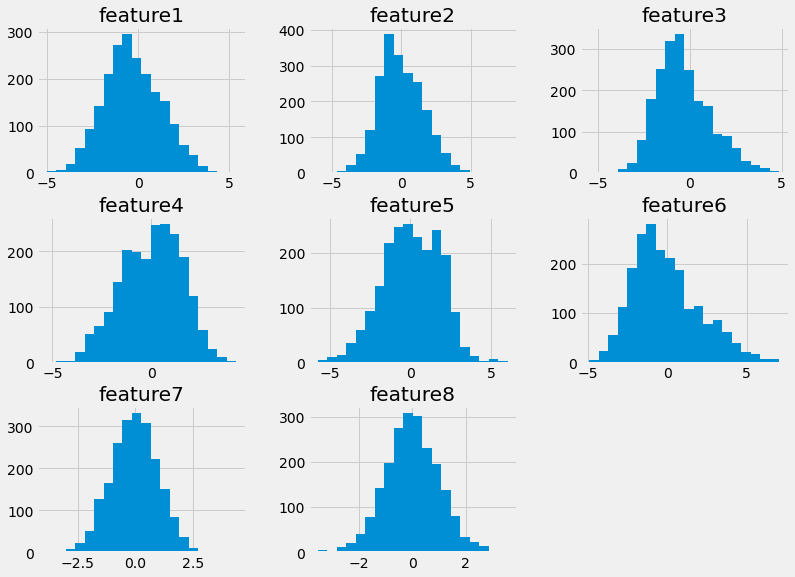

In [ ]:
_ = df.drop(columns='target').hist(bins=20)

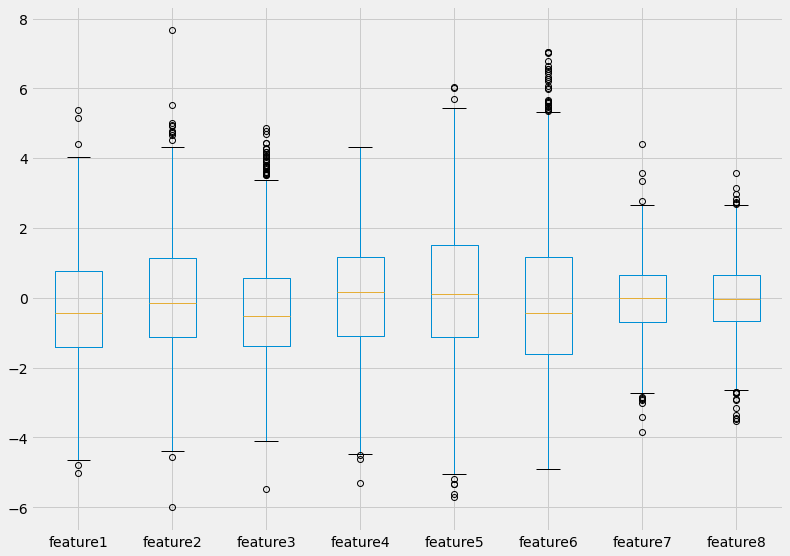

In [101]:
df.drop(columns='target').boxplot()

A simple vista todas las columnas siguen una distribucion normal sobretodo la feature7 y feature8. 

En todas las variables podemos observar algunos valores atipicos, pero son valores factibles.

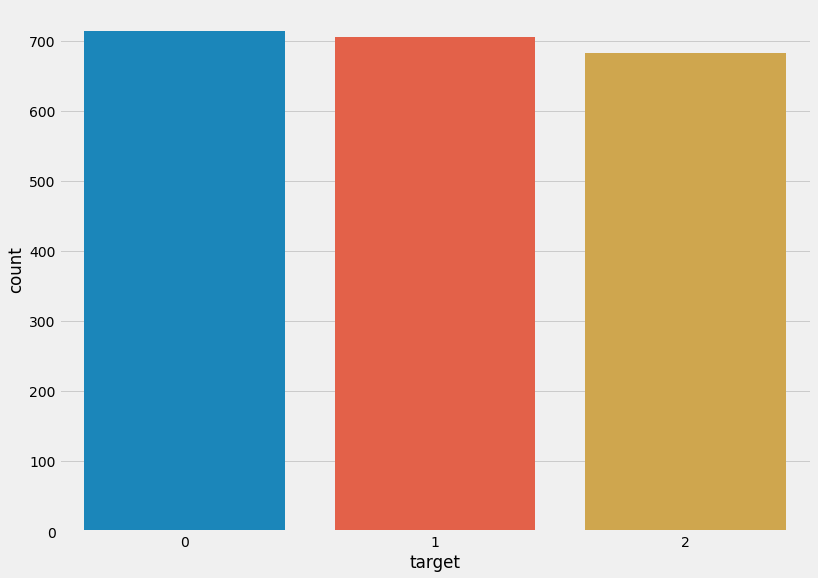

In [ ]:
sns.countplot(data=df, x='target', order=df.target.value_counts().index)

No se observa desbalanceo de clases de la variable target

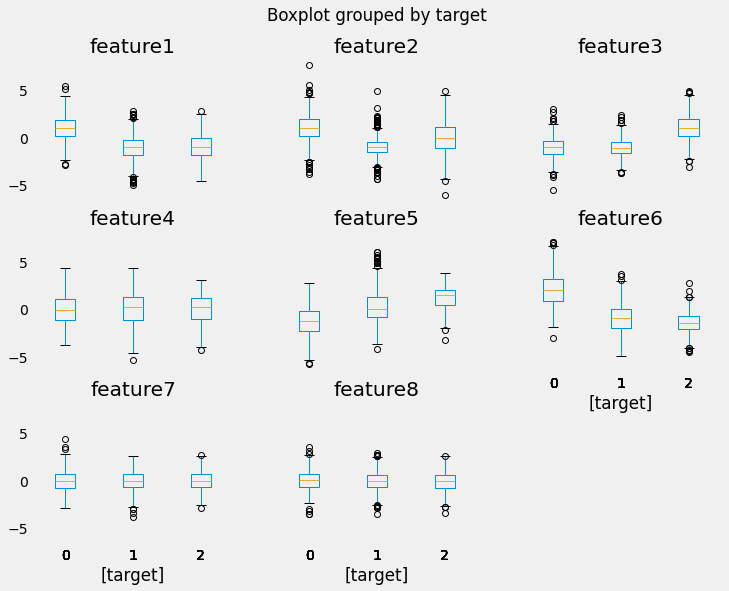

In [ ]:

_ = df.boxplot(by='target', grid=False)

A simple vista se puede observar que la variabilidad de los datos (rango intercuartilico) y la mediana de las cajas es diferente en las variables (feature1, feature2, feature3, feature5, feature6), sin embargo en las variables (feature4, feature7, feature8) la variabilidad de los datos y la mediana son similares, lo que parece indicar que estas tres variables tienen menos incidencia en la prediccion de la variable objetivo (target)

## Feature Selection:

a continuacion vemos las variables que estan mas correlacionadas y son las mas importantes para la variable target

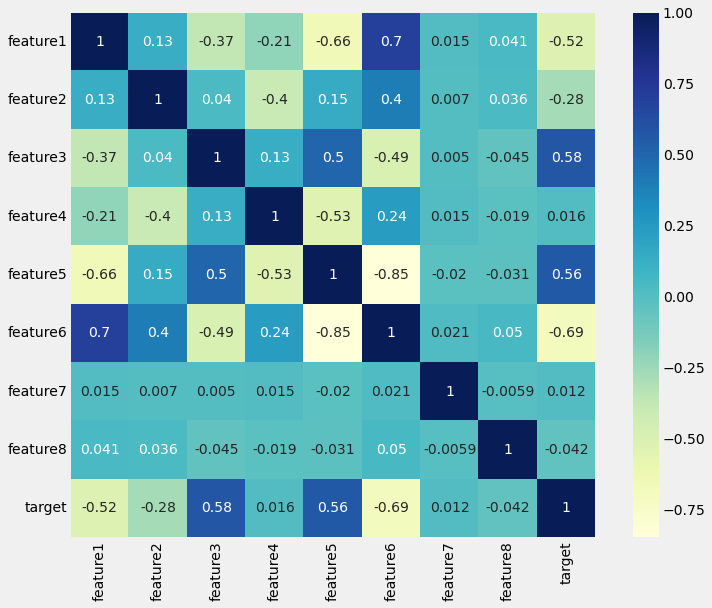

In [ ]:
cor = df.iloc[:,:8].corr()
sns.heatmap(df.corr(), annot = True, cmap="YlGnBu", square=True)

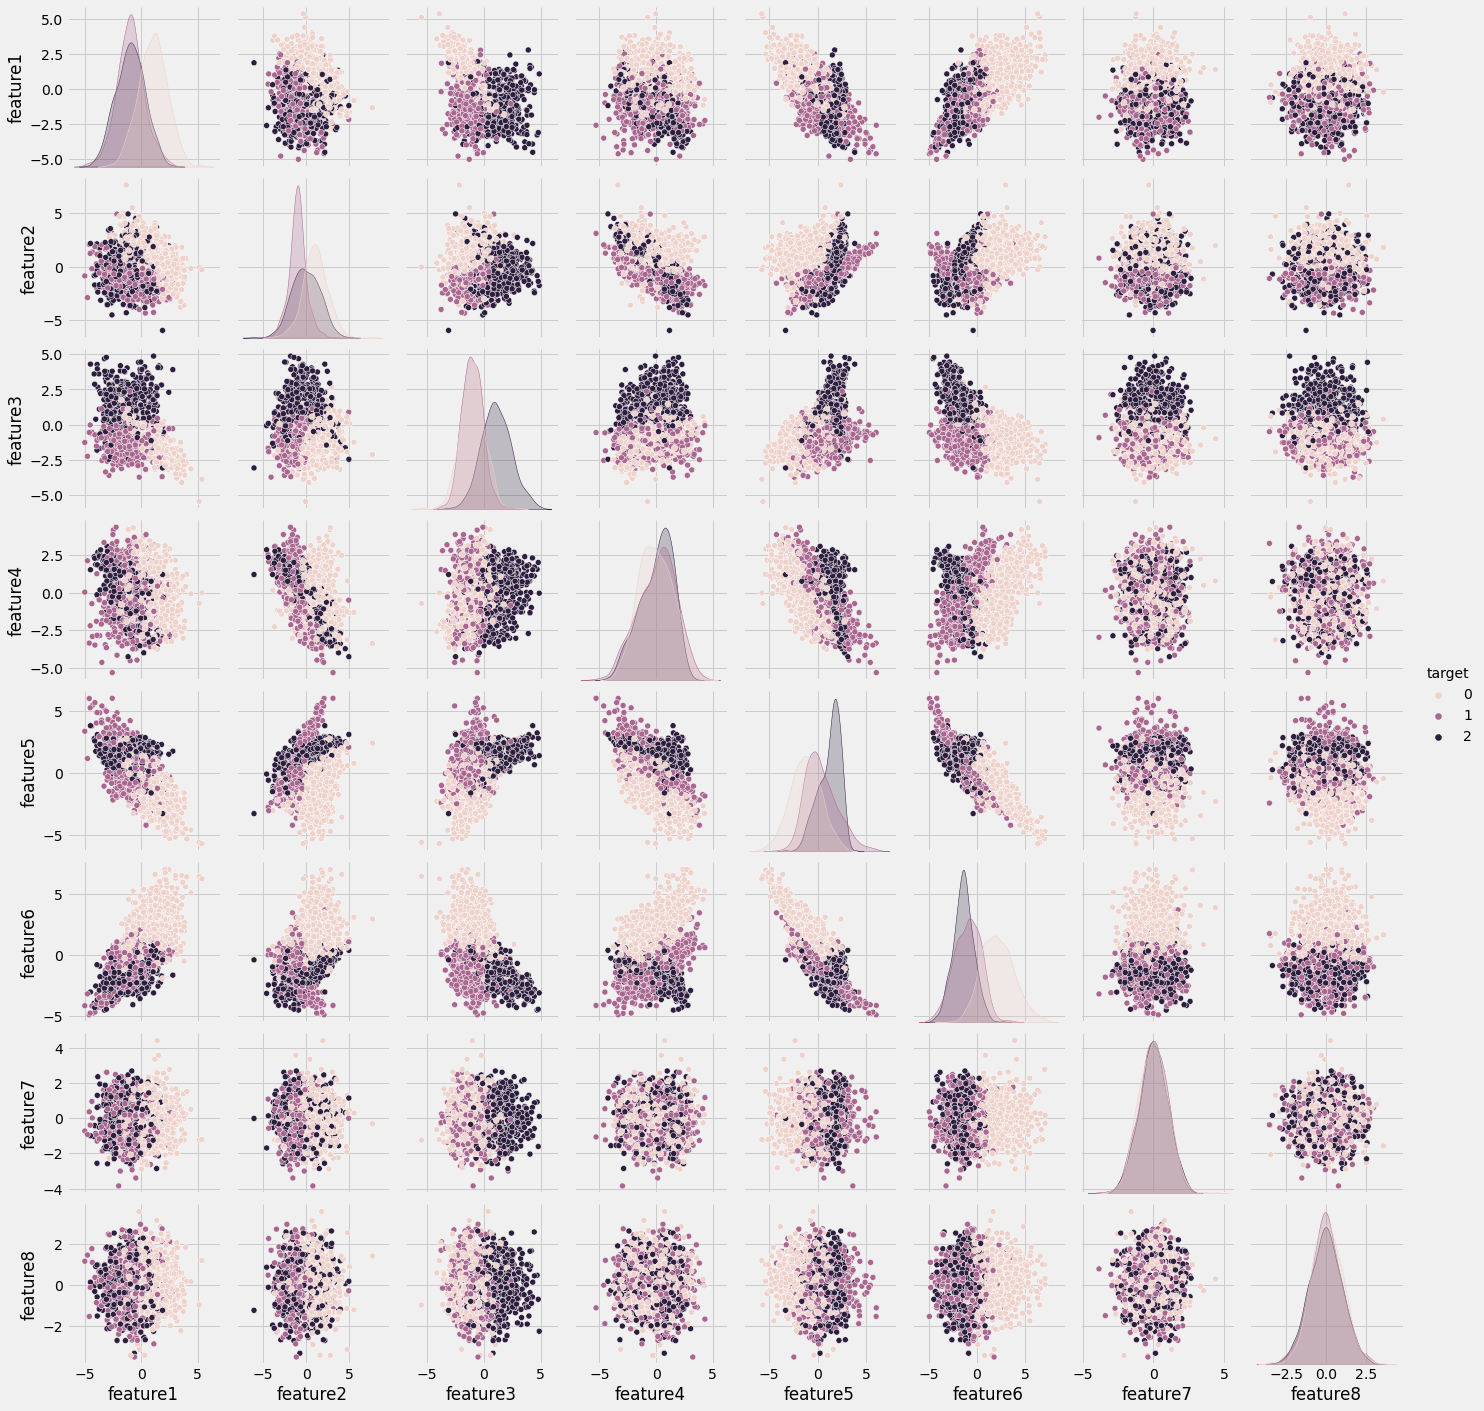

In [ ]:
sns.pairplot(df,hue='target')

Extraemos las 5 caracteristicas mas importantes para usar, las que mas aportan al momento de clasificar.

In [84]:
X=df.drop(columns='target')
y=df['target']
best = SelectKBest(k=5)
X_new = best.fit_transform(X,y)
X_new.shape

(2100, 5)

In [85]:
bool_columns = best.get_support(indices=True)
best_columns = X.columns[bool_columns]
best_columns

Index(['feature1', 'feature2', 'feature3', 'feature5', 'feature6'], dtype='object')

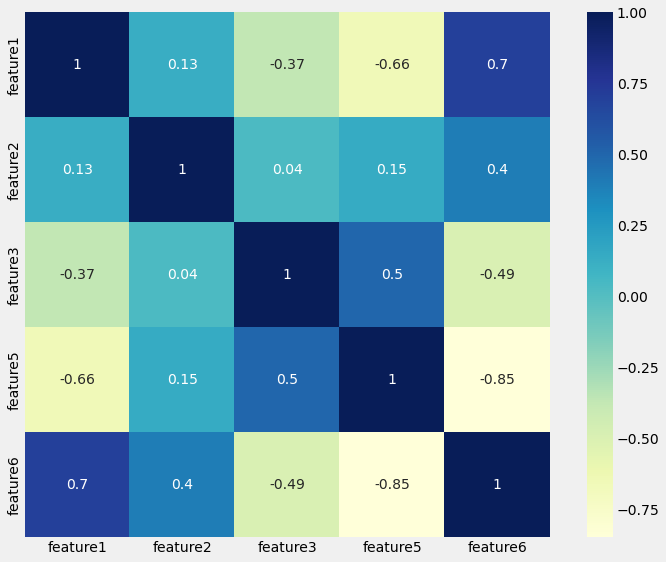

In [ ]:
_ = sns.heatmap(df[best_columns].corr(),square=True,annot=True,cmap='YlGnBu')

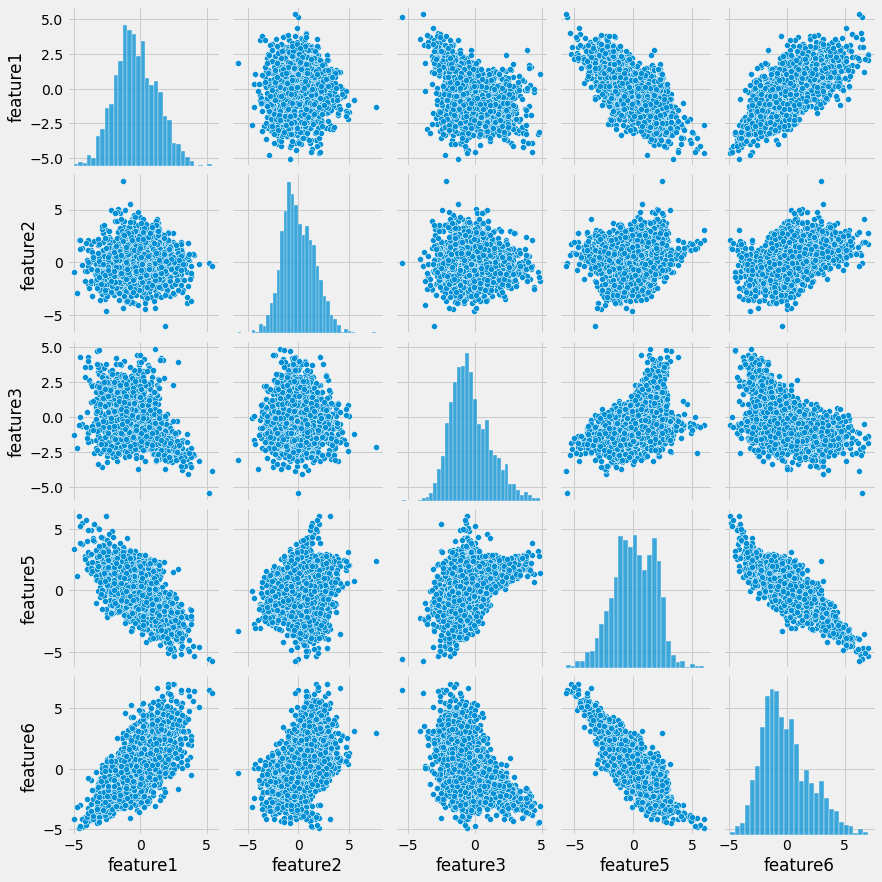

In [ ]:
sns.pairplot(df[best_columns])

## División de los datos en conjuntos separados de entrenamiento y test

In [106]:
# División de los datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns='target'),
                                        df['target'],
                                        random_state = 123
                                    )

Entrenamos el modelo con los valores por defecto de los hiperparametros

Matriz de confusión
-------------------


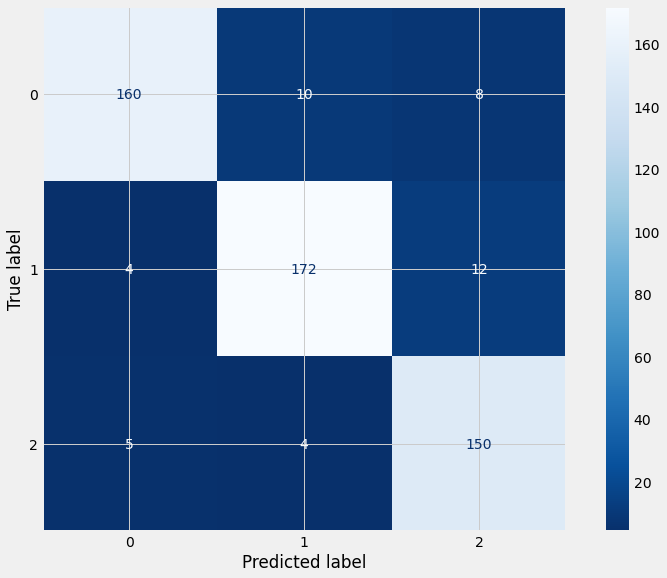


El accuracy de test es: 91.79434671097519 %


In [107]:
forest = RandomForestClassifier(random_state = 123)
modelF = forest.fit(X_train, y_train)
predicciones = modelF.predict(X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
# print(mat_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=mat_confusion, display_labels=y_test.unique())
disp.plot(cmap=plt.cm.Blues_r)
plt.show()
print("")
print(f"El accuracy de test es: {100 * f1_score(y_test, predicciones, average='macro')} %")

In [11]:
print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       178
           1       0.92      0.91      0.92       188
           2       0.88      0.94      0.91       159

    accuracy                           0.92       525
   macro avg       0.92      0.92      0.92       525
weighted avg       0.92      0.92      0.92       525



## Ajuste de hiperparametros


Buscamos la mejor combinación de parametros (n_estimators, max_depth, min_samples_split y min_samples_leaf) que da los mejores resultados en el conjunto de datos de entrenamiento

In [47]:
n_estimators = [20, 50, 100, 300, 500, 800]
max_depth = [2, 5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 4, 10]

In [45]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train,
                                param_name = 'n_estimators',
                                param_range = n_estimators, cv = 3)

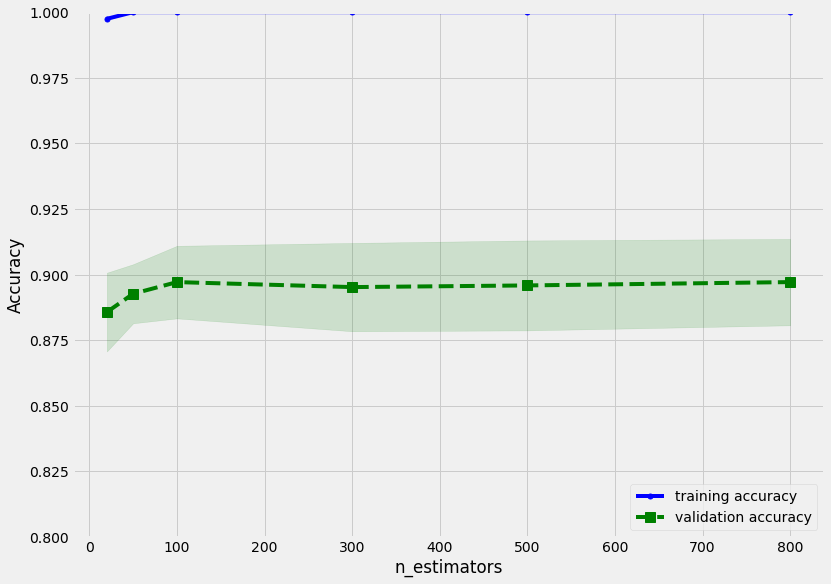

In [46]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.plot(n_estimators, train_mean,    color='blue', marker='o',
    markersize=5,
    label='training accuracy')
plt.fill_between(n_estimators, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
plt.plot(n_estimators, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=10,
    label='validation accuracy')
plt.fill_between(n_estimators,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

In [44]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train,
                                param_name = 'max_depth',
                                param_range = max_depth, cv = 3)

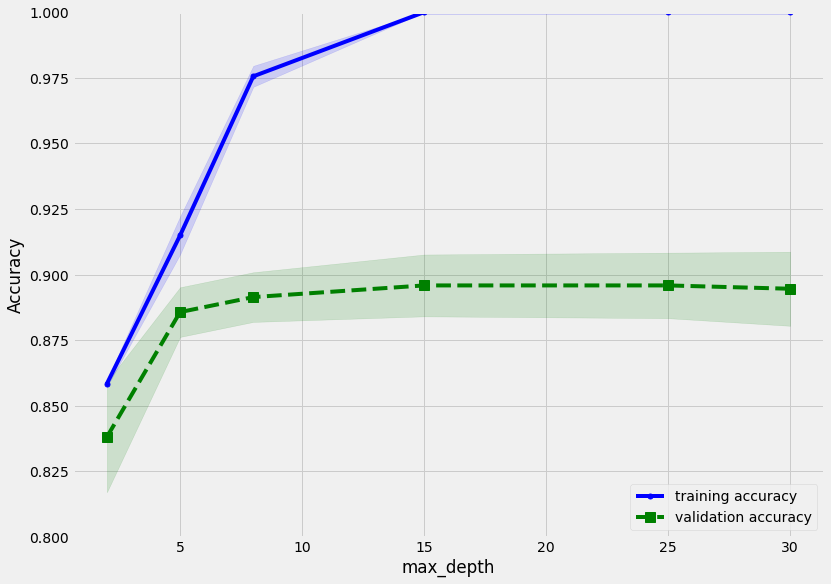

In [40]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.plot(max_depth, train_mean,    color='blue', marker='o',
    markersize=5,
    label='training accuracy')
plt.fill_between(max_depth, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
plt.plot(max_depth, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=10,
    label='validation accuracy')
plt.fill_between(max_depth,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

In [29]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train,
                                param_name = 'min_samples_split',
                                param_range = min_samples_split, cv = 3)

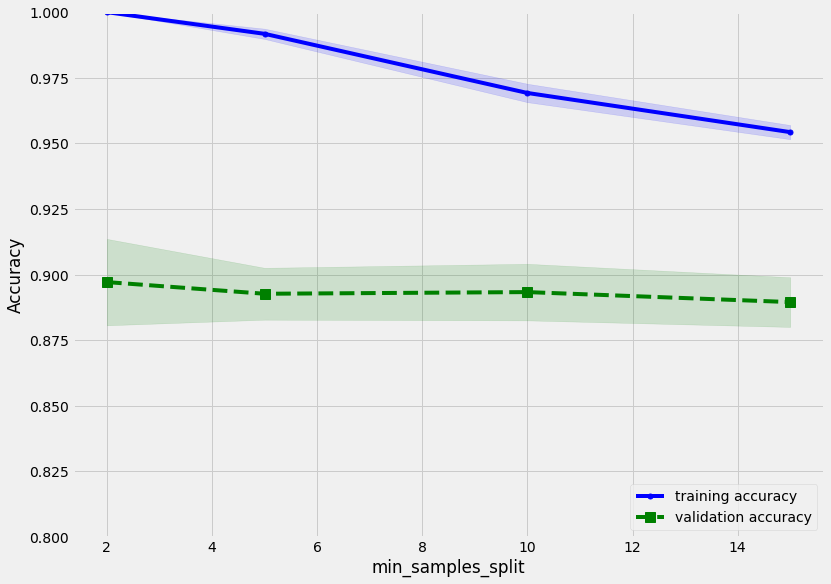

In [31]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.plot(min_samples_split, train_mean,    color='blue', marker='o',
    markersize=5,
    label='training accuracy')
plt.fill_between(min_samples_split, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
plt.plot(min_samples_split, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=10,
    label='validation accuracy')
plt.fill_between(min_samples_split,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

In [48]:
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train,
                                param_name = 'min_samples_leaf',
                                param_range = min_samples_leaf, cv = 3)

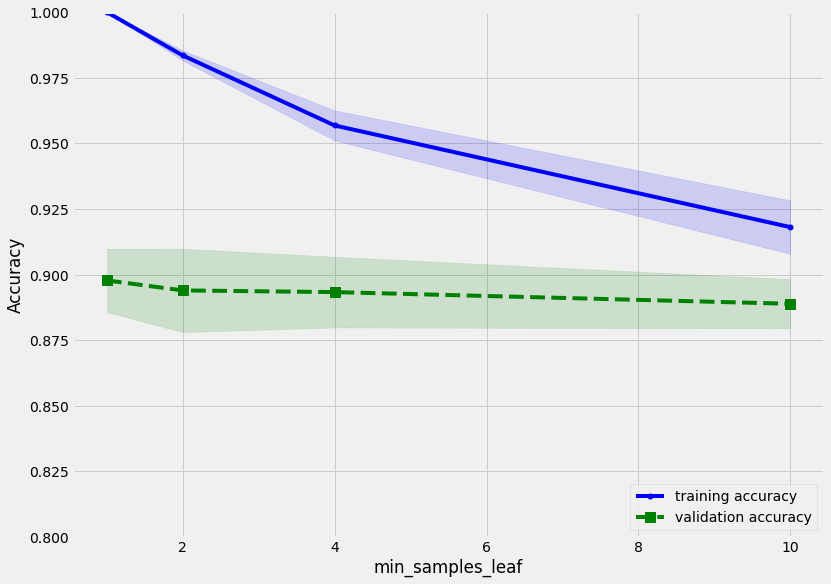

In [49]:
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)

plt.plot(min_samples_leaf, train_mean,    color='blue', marker='o',
    markersize=5,
    label='training accuracy')
plt.fill_between(min_samples_leaf, train_mean + train_std,
    train_mean - train_std, alpha=0.15,
    color='blue')
plt.plot(min_samples_leaf, test_mean,
    color='green', linestyle='--',
    marker='s', markersize=10,
    label='validation accuracy')
plt.fill_between(min_samples_leaf,
    test_mean + test_std,
    test_mean - test_std,
    alpha=0.15, color='green')
plt.grid(True)
plt.legend(loc='lower right')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1.0])
plt.show()

los valores optimos encontrados con diferentes valores de un solo hiperparametro son :


*   n_estimators: 100
*   min_samples_split : 2
*   max_depth: 15
*   min_samples_leaf: 1

Con los mejores hiperparametros idenficados, se reentrena el modelo:





Matriz de confusión
-------------------


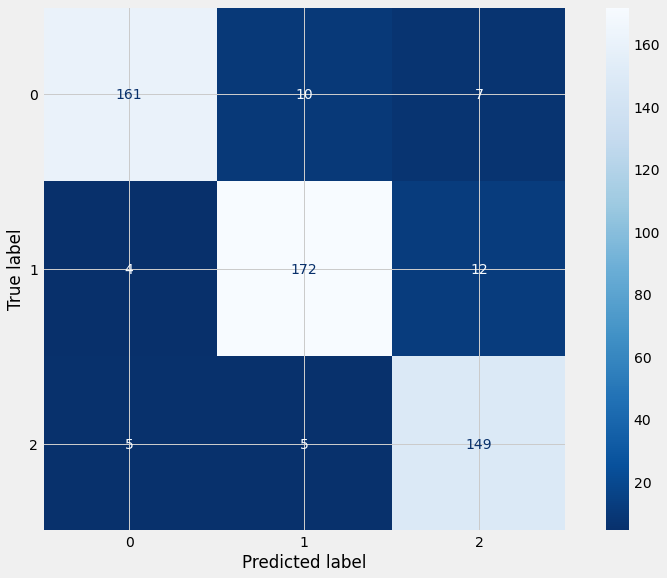


El accuracy de test es: 91.79785581215508 %


In [53]:
forestVC = RandomForestClassifier(random_state = 123,
                                  n_estimators = 100,
                                  max_depth = 15, 
                                  min_samples_split = 2,  min_samples_leaf = 1) 
modelVC = forestVC.fit(X_train, y_train) 
predicciones = modelVC.predict(X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
# print(mat_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=mat_confusion, display_labels=y_test.unique())
disp.plot(cmap=plt.cm.Blues_r)
plt.show()
print("")
print(f"El accuracy de test es: {100 * f1_score(y_test, predicciones, average='macro')} %")

La mejora que se aprecia es minima, solo de un .0035

#Modelo dataset original
##Grid Search basado en validación cruzada

Otra forma de elegir los hiperparametros que mejor se ajustan mediante busqueda exhaustiva de todas las combinaciones posibles. 

In [54]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'n_estimators': [100, 200, 300, 500, 800],
                 'min_samples_split' : [2, 3, 5, 10],
                 'max_depth'   : [10, 15, 20, 25, 30],
                 'min_samples_leaf' : [1, 2, 5, 10],
                #  'criterion'   : ['gini', 'entropy']
             }

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = RandomForestClassifier(random_state = 123),
        param_grid = param_grid,
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid.fit(X=X_train, y=y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,mean_train_score,std_train_score
87,15,1,3,300,0.907090,0.015529,0.999894,0.000270
247,25,1,3,300,0.906878,0.015408,0.999894,0.000270
327,30,1,3,300,0.906878,0.015408,0.999894,0.000270
89,15,1,3,800,0.906878,0.016705,0.999947,0.000198


In [55]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300} : 0.9070899470899472 accuracy


## Importancia de predictores

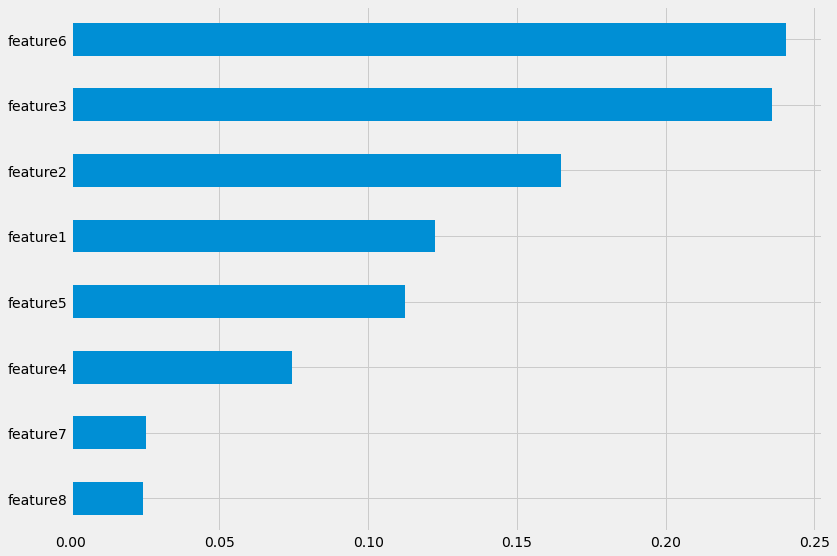

In [56]:
modelo_final = grid.best_estimator_
modelo_final.feature_importances_
feature_scores = pd.Series(modelo_final.feature_importances_, index=X_train.columns).sort_values()
feature_scores.plot(kind='barh')

Acorde a los datos de entrenamiento feature6 y feature3 son los predictores mas influyentes

## Predicción y evaluación del modelo

In [57]:
# Error de test del modelo final
# ==============================================================================
predicciones = modelo_final.predict(X = X_test)
predicciones[:10]

array([0, 1, 2, 1, 2, 1, 1, 2, 2, 2])

Matriz de confusión
-------------------


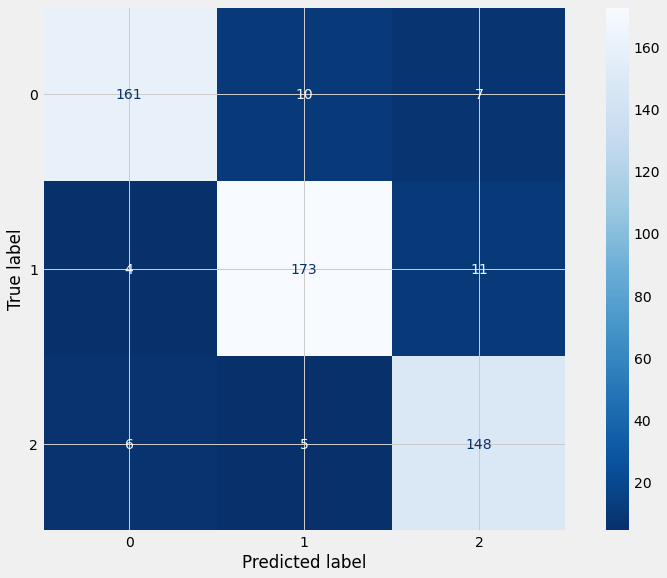


El accuracy de test es: 91.78726999595135 %


In [58]:
mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
# print(mat_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=mat_confusion, display_labels=y_test.unique())
disp.plot(cmap=plt.cm.Blues_r)
plt.show()
print("")
print(f"El accuracy de test es: {100 * f1_score(y_test, predicciones, average='macro')} %")


El codigo tomo aproximadamente 70 minutos en terminar y el resultado es un poco peor que con el metodo anterior. 

#Modelo dataset (best_columns)

Matriz de confusión
-------------------


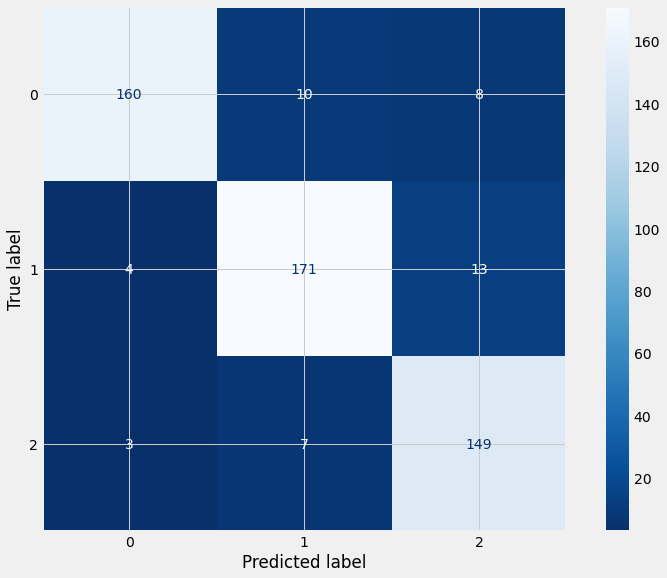


El accuracy de test es: 91.42952586523356 %


In [87]:
forestVC = RandomForestClassifier(random_state = 123,
                                  n_estimators = 100,
                                  max_depth = 15, 
                                  min_samples_split = 2,  min_samples_leaf = 1) 

modelVC = forestVC.fit(X_train[best_columns], y_train) 

# Predicción y evaluación del modelo
predicciones = modelVC.predict(X_test[best_columns])

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
# print(mat_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=mat_confusion, display_labels=y_test.unique())
disp.plot(cmap=plt.cm.Blues_r)
plt.show()
print("")
print(f"El accuracy de test es: {100 * f1_score(y_test, predicciones, average='macro')} %")

Se ha utilizado las 5 caracteristicas mas importantes del modelo y la precision empeora

#Modelo dataset (menos feature7)

Matriz de confusión
-------------------


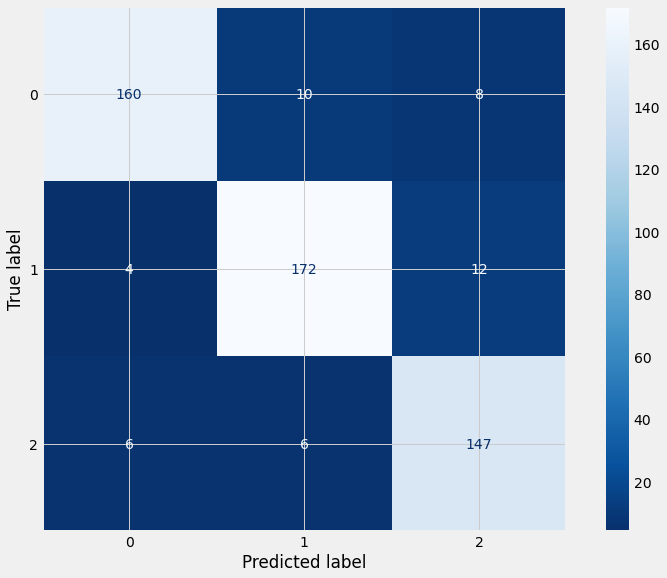


El accuracy de test es: 91.20914459012934 %


In [93]:
forestVC = RandomForestClassifier(random_state = 123,
                                  n_estimators = 100,
                                  max_depth = 15, 
                                  min_samples_split = 2,  min_samples_leaf = 1) 

modelVC = forestVC.fit(X_train[X_train.columns.difference(['feature7'])], y_train) 

# Predicción y evaluación del modelo
predicciones = modelVC.predict(X_test[X_test.columns.difference(['feature7'])])

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
# print(mat_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=mat_confusion, display_labels=y_test.unique())
disp.plot(cmap=plt.cm.Blues_r)
plt.show()
print("")
print(f"El accuracy de test es: {100 * f1_score(y_test, predicciones, average='macro')} %")

Se ha eliminado la caracteristica menos importante del modelo y se ha visto que no ha mejorado la precisión obteniendo un peor modelo. 

#Modelo dataset (menos feature7 y feature8)

Matriz de confusión
-------------------


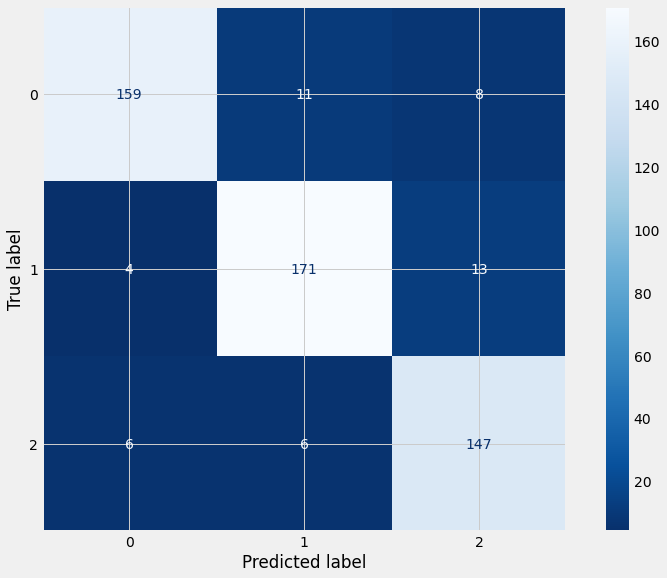


El accuracy de test es: 90.83611832869151 %


In [94]:
forestVC = RandomForestClassifier(random_state = 123,
                                  n_estimators = 100,
                                  max_depth = 15, 
                                  min_samples_split = 2,  min_samples_leaf = 1) 

modelVC = forestVC.fit(X_train[X_train.columns.difference(['feature7','feature8'])], y_train) 

# Predicción y evaluación del modelo
predicciones = modelVC.predict(X_test[X_test.columns.difference(['feature7','feature8'])])

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
# print(mat_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=mat_confusion, display_labels=y_test.unique())
disp.plot(cmap=plt.cm.Blues_r)
plt.show()
print("")
print(f"El accuracy de test es: {100 * f1_score(y_test, predicciones, average='macro')} %")

Si elimino del modelo la segunda caracteristica mas importante del dataset la precision del modelo empeora mas todavia. 

#Guardamos datos 

Recuperamos el mejor modelo obtenido y guardamos los datos de la predicción

Matriz de confusión
-------------------


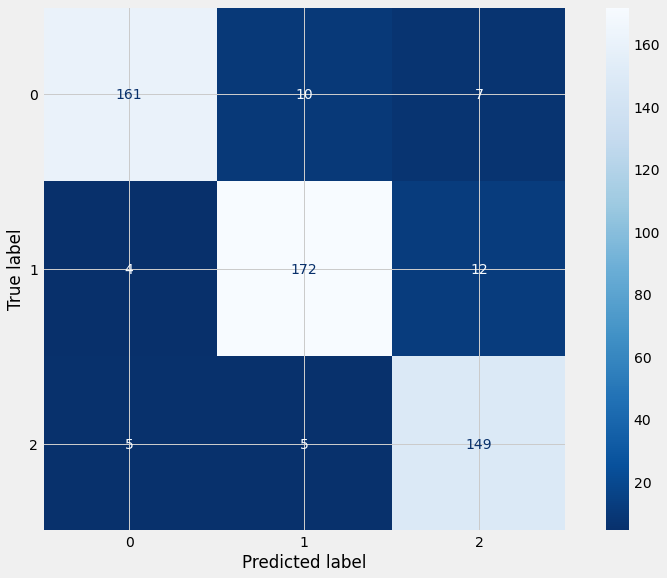


El accuracy de test es: 91.79785581215508 %


In [97]:
forestVC = RandomForestClassifier(random_state = 123,
                                  n_estimators = 100,
                                  max_depth = 15, 
                                  min_samples_split = 2,  min_samples_leaf = 1) 
modelVC = forestVC.fit(X_train, y_train) 
predicciones = modelVC.predict(X_test)

mat_confusion = confusion_matrix(
                    y_true    = y_test,
                    y_pred    = predicciones
                )

accuracy = accuracy_score(
            y_true    = y_test,
            y_pred    = predicciones,
            normalize = True
           )

print("Matriz de confusión")
print("-------------------")
# print(mat_confusion)
disp = ConfusionMatrixDisplay(confusion_matrix=mat_confusion, display_labels=y_test.unique())
disp.plot(cmap=plt.cm.Blues_r)
plt.show()
print("")
print(f"El accuracy de test es: {100 * f1_score(y_test, predicciones, average='macro')} %")

In [98]:
print(
    classification_report(
        y_true = y_test,
        y_pred = predicciones
    )
)

              precision    recall  f1-score   support

           0       0.95      0.90      0.93       178
           1       0.92      0.91      0.92       188
           2       0.89      0.94      0.91       159

    accuracy                           0.92       525
   macro avg       0.92      0.92      0.92       525
weighted avg       0.92      0.92      0.92       525



In [99]:
# guardamos los datos de la prediccion del mejor modelo en un csv
df_res = pd.DataFrame(predicciones,columns=['final_status'])
df_res.to_csv('uoc_predicciones.csv',index=None)

#Referencias



1.   https://www.cienciadedatos.net/documentos/py08_random_forest_python.html
2.   https://www.kaggle.com/prashant111/random-forest-classifier-tutorial
3.   https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6




